<h1>Libraries</h1>

In [1]:
# My library
import SARAH as sa

# Basic libraries
import time
import numpy as np

import wfdb
import pandas as pd
import statistics as st

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

%matplotlib widget

from sklearn.svm import SVR
from scipy.signal import argrelextrema

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs

<h1>Read processed data from AF</h1>

In [38]:
# Patient number
target = "08"

# Define path to data
file = "/Users/jesus.fuentes/Developer/Data/LTAF_84P/" + target

# Read data from binary files
data = wfdb.rdrecord(file)

# Assign ECG signals
ecgs = data.p_signal

# Determine the sampling frequency
f0 = data.fs

# Read only one ECG channel
ECG = ecgs[:, 0]

# Filter ECG signal via Butterworth
ECG = sa.filterECG(ECG, sampling_rate=f0)

# Open h5 file as pandas df
dist = pd.HDFStore('../LTAF_84P_stats/LTAF_84P-' + target + '-t_width-60-dists.h5')
peak = pd.HDFStore('../LTAF_84P_stats/LTAF_84P-' + target + '-t_width-60-peaks.h5')

# P, R and T distributions
rdists = []
pdists = []
tdists = []
for n in range( len(dist.keys()) ):
    rdists.append( dist['df' + str(n)]['R_t'] )
    pdists.append( dist['df' + str(n)]['P_t'] )
    tdists.append( dist['df' + str(n)]['T_t'] )

# P, R and T peaks
rpeaks = []
ppeaks = []
tpeaks = []
for n in range( len(peak.keys()) ):
    rpeaks.append( peak['df' + str(n)]['R'] )
    ppeaks.append( peak['df' + str(n)]['P'] )
    tpeaks.append( peak['df' + str(n)]['T'] )

# Redefine x-domain and ticks
rngb = np.arange(1, 40) / 20
xdom = np.linspace(np.min(rngb), np.max(rngb), num=500) # could be generalised

dist.close()
peak.close()

# Sanitise peaks
nrpeak = [sa.removeNAN(rpeaks[n]) for n in range(len(rpeaks))]
nppeak = [sa.removeNAN(ppeaks[n]) for n in range(len(ppeaks))]
ntpeak = [sa.removeNAN(tpeaks[n]) for n in range(len(tpeaks))]

# Compute intervals between peaks
RRI = [np.ediff1d(nrpeak[n], to_begin=0) / f0 for n in range(len(nrpeak))]

# Mean and variance of peak intervals
MRRI = [st.mean(RRI[n]) for n in range(len(RRI))]
VARR = [st.variance(RRI[n]) for n in range(len(RRI))]

MRRI = np.asarray(MRRI)
VARR = np.asarray(VARR)

In [39]:
# The window is updated in intervals of:
winwidth = 50     # seconds
start_at = 30*60  # seconds

# Raw time
tr = winwidth * np.linspace(0, len(MRRI), num=len(MRRI)) + start_at

# Time with format
tt = [time.strftime('%H:%M:%S', time.gmtime(tr[i])) for i in range(len(tr))]

# Reshaping vectors
t0 = tr[:, np.newaxis]
y0 = MRRI.ravel()

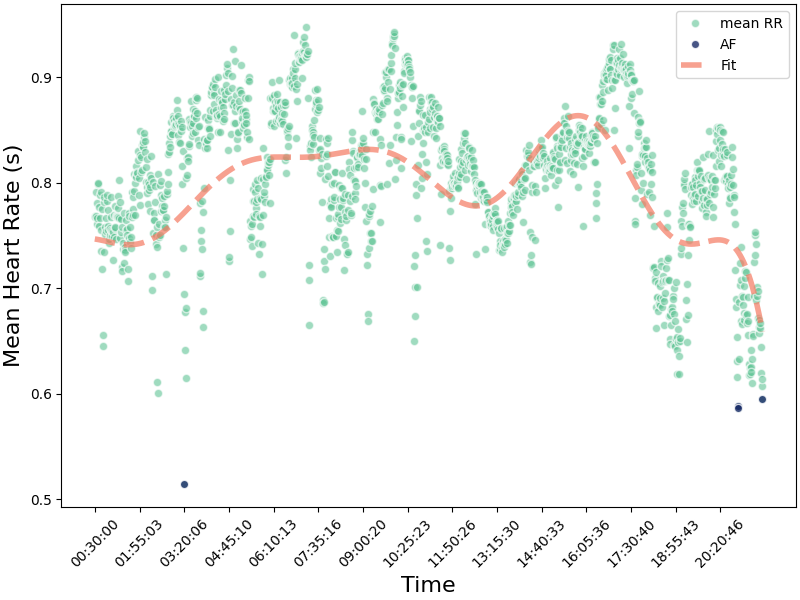

In [40]:
# Fix accordingly
threshold = 0.6

# Computing fit
Y0 = SVR(kernel="rbf", C=200, gamma='scale', epsilon=0.1).fit(t0, y0).predict(t0)

# For local maxima
#maxY0 = argrelextrema(Y0, np.greater)[0]

# For local minima
#minY0 = argrelextrema(Y0, np.less)[0]

# Coordinates of trending curves
#x1_trend, y1_trend = [ t0[maxY0[1]], t0[minY0[2]] ] , [ Y0[maxY0[1]] , Y0[minY0[2]] ]
#x2_trend, y2_trend = [ t0[maxY0[0]], t0[minY0[2]] ] , [ Y0[maxY0[0]] , Y0[minY0[2]] ]
#x3_trend, y3_trend = [ t0[maxY0[0]], t0[maxY0[1]] ] , [ Y0[maxY0[0]] , Y0[maxY0[1]] ]

# Clear output
plt.close()

# Define figure
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 6))

# Call plots
plt.plot(t0, MRRI, 'o', color='#5FC495', mec='w', alpha=0.6, label='mean RR')
plt.plot(t0[np.where(MRRI < threshold)[0]], MRRI[MRRI < threshold], 'o', 
         color='#192A67', mec='w', alpha=0.8, label='AF')
plt.plot(t0, Y0, '--', lw=4, color='#F47961', alpha=0.7, label='Fit')
#plt.plot(x1_trend, y1_trend, '-o', color='grey', lw=3, ms=8)
#plt.plot(x2_trend, y2_trend, '-o', color='grey', lw=3, ms=8)
#plt.plot(x3_trend, y3_trend, '-o', color='#3551E4', lw=3, ms=8)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Mean Heart Rate (s)', fontsize=16)
plt.xticks(tr, labels=tt, rotation=45)
#plt.title('HR oscillations from AF-patient', fontsize=18, weight='bold')
plt.locator_params(axis="x", nbins=15)
plt.legend(loc='best')

#plt.savefig('hroscillations-LTAF-' + str(target)  + '.eps', format='eps')

plt.show()

In [22]:
region = 650

# Split MRR segments
m_AF = MRRI[region: ]
m_NAF = MRRI[0: region]

# Split MRR segments
v_AF = VARR[region: ]
v_NAF = VARR[0: region]

# Label AF events
AF = np.multiply(m_AF < threshold, 1)

# Sample universe for training and testing
train = np.array((m_AF, v_AF)).T
test = np.array((m_NAF, v_NAF)).T

# Training model
model = LogisticRegression(solver='lbfgs')
model.fit(train, AF)

# Testing probability
pAF = model.predict_proba(test)

<h1>Read processed data from SHHS</h1>

In [ ]:
import pyedflib as edf

# Patient number
patient = "200003"

# Set path accordingly
path = "../polysomnography/edfs/shhs1/shhs1-"

# Open file
file = edf.EdfReader(path + patient + ".edf")

# Extract data
chn = 3

# Original sampling frequency
f0 = int(file.samplefrequency(chn))

# Close file
file.close()

# Open h5 file as pandas df
dist = pd.HDFStore('SSH1-' + patient + '-t_width-60-dists.h5')
peak = pd.HDFStore('SSH1-' + patient + '-t_width-60-peaks.h5')

# P, R and T distributions
rdists = []
pdists = []
tdists = []
for n in range( len(dist.keys()) ):
    rdists.append( dist['df' + str(n)]['R_t'] )
    pdists.append( dist['df' + str(n)]['P_t'] )
    tdists.append( dist['df' + str(n)]['T_t'] )

# P, R and T peaks
rpeaks = []
ppeaks = []
tpeaks = []
for n in range( len(peak.keys()) ):
    rpeaks.append( peak['df' + str(n)]['R'] )
    ppeaks.append( peak['df' + str(n)]['P'] )
    tpeaks.append( peak['df' + str(n)]['T'] )

# Redefine x-domain and ticks
rngb = np.arange(1, 40) / 20
xdom = np.linspace(np.min(rngb), np.max(rngb), num=500) # could be generalised

dist.close()
peak.close()

# Sanitise peaks
nrpeak = [sa.removeNAN(rpeaks[n]) for n in range(len(rpeaks))]
nppeak = [sa.removeNAN(ppeaks[n]) for n in range(len(ppeaks))]
ntpeak = [sa.removeNAN(tpeaks[n]) for n in range(len(tpeaks))]

# Compute intervals between peaks
RRI = [np.ediff1d(nrpeak[n], to_begin=0) / f0 for n in range(len(nrpeak))]

# Mean and variance of peak intervals
MRRI = [st.mean(RRI[n]) for n in range(len(RRI))]
VARR = [st.variance(RRI[n]) for n in range(len(RRI))]

MRRI = np.asarray(MRRI)
VARR = np.asarray(VARR)

In [ ]:
# The window is updated in intervals of:
winwidth = 50     # seconds
start_at = 20*60  # seconds

# Raw time
tr = winwidth * np.linspace(0, len(MRRI), num=len(MRRI)) + start_at

# Time with format
tt = [time.strftime('%H:%M:%S', time.gmtime(tr[i])) for i in range(len(tr))]

# Reshaping vectors
t0 = tr[:, np.newaxis]
y0 = MRRI.ravel()

# Fix accordingly
threshold = MRRI.mean()

# SVR Model
svr_rbf = SVR(kernel="rbf", C=200, gamma='scale', epsilon=0.1)

# Clear output
plt.close()

# Define figure
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 6))

# Call plots
plt.plot(t0, MRRI, 'o', color='#5FC495', mec='w', alpha=0.6, label='mean RR')
plt.plot(t0, svr_rbf.fit(t0, y0).predict(t0), '--', lw=4, color='#F47961', alpha=0.7, label='SVR Fit')
plt.xticks(tr, labels=tt, rotation=45)
plt.locator_params(axis="x", nbins=15)
plt.legend(loc='best')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Mean Heart Rate (s)', fontsize=16)
plt.title('HR oscillations from non-AF-patient', fontsize=18, weight='bold')

plt.savefig('hroscillations-SHHS1-' + str(patient)  + '.eps', format='eps')

plt.show()

<h2>Display cluster of plots</h2>

In [ ]:
num = 1
sa.diagrams(xdom, rpeaks, rdists, f0, num, 'R-R distributions')